In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json


In [25]:
# import packages
import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt

In [26]:
json_1 = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
json_2 = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'


Load data into `Pandas.DataFrame`

In [27]:
def load_json(jfile):
    data = []
    with open(jfile) as f:
        for line in f.readlines():
            j = json.loads(line)
            url, headline, sarcastic = j['article_link'], j['headline'], j['is_sarcastic']
            data.append([url, headline, sarcastic])
    return pd.DataFrame(data, columns=['article_link', 'headline', 'is_sarcastic'])

print("✅✅✅ SESSION DONE")

✅✅✅ SESSION DONE


In [28]:
df = load_json(json_1)
df2 = load_json(json_2)
df2

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1
...,...,...,...
28614,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
28615,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
28616,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
28617,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


Now check the distribution (ratio) of our target `is_sarcastic`.

In [29]:
df.is_sarcastic.value_counts(normalize=True), df.is_sarcastic.value_counts()

(0    0.561047
 1    0.438953
 Name: is_sarcastic, dtype: float64,
 0    14985
 1    11724
 Name: is_sarcastic, dtype: int64)

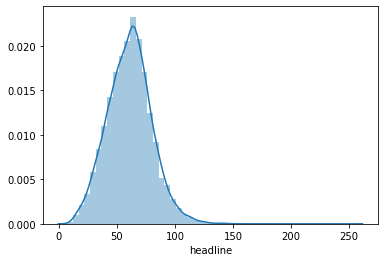

In [30]:
# A birdview of headline length. Seems the majority has a length of 70, that's about 5 to 15 words, which makes sence.
sbs.distplot(df.headline.str.len())


The data is well-balanced, which is rare in reality but great for our practicing purpose.

Now we will try Naive Bayes as our base model.

## Building Base Model: Naive Bayes
First step, we should tokenize texts into vectors.

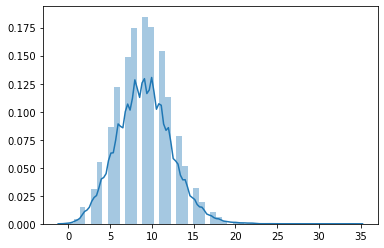

In [31]:
vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.headline)
train_inputs = tokenizer.texts_to_sequences(df.headline)
sbs.distplot([len(l) for l in train_inputs])

See, the above graph confirms our guess: most headline has 5 - 15 words. 


In [32]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['is_sarcastic']

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([ 307,  678, 3336, 2297,   47,  381, 2575,    5, 2576, 8433,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [33]:
nb = sklearn.naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Validate how the model performs. 

Turs out that the `accuracy_score` is only 0.58, which is merely a little better than random guess.
But at least wew know what to expect now. We're going to try more powerful models, e.g., CNN, to see whether we can reach a `accuracy_score = 0.7` or higher.

In [34]:
y_preds = nb.predict(X_val)
print(f"Accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Accuracy score 0.5718831898165481
Classification report
               precision    recall  f1-score   support

           0       0.60      0.69      0.64      3007
           1       0.51      0.42      0.46      2335

    accuracy                           0.57      5342
   macro avg       0.56      0.55      0.55      5342
weighted avg       0.56      0.57      0.56      5342



# Another model: Keras LSTM

In [35]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 64)            41216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/30
18944/19230 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.6595
Epoch 00001: val_accuracy improved from -inf to 0.84090, saving model to model_best.hdf5
19230/19230 [==============================] - 5s 275us/sample - loss: 0.5970 - accuracy: 0.6625 - val_loss: 0.3698 - val_accuracy: 0.8409
Epoch 2/30
18688/19230 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.8860
Epoch 00002: val_accuracy improved from 0.84090 to 0.85587, saving model to model_best.hdf5
19230/19230 [==============================] - 2s 88us/sample - loss: 0.2991 - accuracy: 0.8854 - val_loss: 0.3324 - val_accuracy: 0.8559
Epoch 3/30
18944/19230 [============================>.] - ETA: 0s - loss: 0.1935 - accuracy: 0.9331
Epoch 00003: val_accuracy did not improve from 0.85587
19230/19230 [==============================] - 2s 97us/sample - loss: 0.1934 - accuracy: 0.9331 - val_loss: 0.3765 - val_accuracy: 0.8493


In [37]:
model = tf.keras.models.load_model('model_best.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Test accracy score 0.8566080119805316
Classification report
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      3007
           1       0.85      0.81      0.83      2335

    accuracy                           0.86      5342
   macro avg       0.86      0.85      0.85      5342
weighted avg       0.86      0.86      0.86      5342



In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = y_preds
y_test=y_val

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

# print('\nTRAIN METRIC ----------------------')
# print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[2680  327]
 [ 439 1896]]

============TEST METRICS=============
Accuracy: 85.66080119805316%
Precision: 85.2901484480432%
Recall: 81.19914346895075%
F1-score: 83.19438350153577


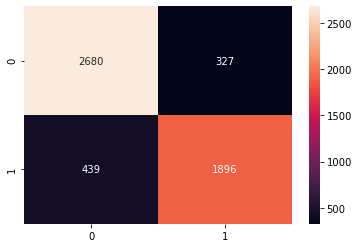

In [40]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

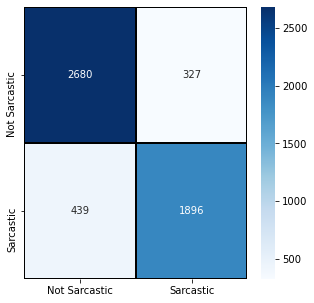

In [42]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

Now we can see, the result is better. The validation accuracy has improved from `0.58` to `0.8521`, which is not ideal, but good enough to detect sarcasm by reading a headline of an article.

A close view will also finds out that this model is apparrenly overfitting our dataset. We will also do experiments on word embedding and BERT later to seen any improvement of our model. 

# WordVector Embedding + LSTM

We now use pretrained wordvector https://code.google.com/archive/p/word2vec/ of Google News (after all, we're dealing with article headlines). 

The vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).

In [44]:
%%time
import gensim.downloader as api

def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
    embed_size = 300 # Google news vector is 300-dimensional
    vector = api.load(pretrained)
    zeros = [0] * embed_size
    matrix = np.zeros((vocab_size, embed_size)) 
    
    for word, i in word_index.items():
        if i >= vocab_size or word not in vector: continue 
        matrix[i] = vector[word]
    
    print("Embed word vector completed.")
    return matrix

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 18.4 µs


Update embedding layer weights of our model

In [47]:
%%time
pretrained = 'glove-wiki-gigaword-300'
matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

Embed word vector completed.
CPU times: user 3min 30s, sys: 1.29 s, total: 3min 32s
Wall time: 3min 33s


In [48]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           330240    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080

Re run our model to see if any improvements we got.

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best_embed.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/30
18432/19230 [===========================>..] - ETA: 0s - loss: 0.5944 - accuracy: 0.6752
Epoch 00001: val_accuracy improved from -inf to 0.78241, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 3s 178us/sample - loss: 0.5912 - accuracy: 0.6787 - val_loss: 0.4652 - val_accuracy: 0.7824
Epoch 2/30
19200/19230 [============================>.] - ETA: 0s - loss: 0.4157 - accuracy: 0.8247
Epoch 00002: val_accuracy improved from 0.78241 to 0.84230, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 1s 51us/sample - loss: 0.4158 - accuracy: 0.8246 - val_loss: 0.3603 - val_accuracy: 0.8423
Epoch 3/30
18688/19230 [============================>.] - ETA: 0s - loss: 0.3331 - accuracy: 0.8667
Epoch 00003: val_accuracy improved from 0.84230 to 0.85260, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 1s 46us/sample - loss: 0.3326 - accu

From the training history, we can see performance of this model is pretty similiar to our previous one. Thus, we know pretrained NLP models are not going help us much. We have to find other ways to improve the score.

In [50]:
model = tf.keras.models.load_model('model_best_embed.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

Test accracy score 0.8627854736053913


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = y_preds
y_test=y_val

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

# print('\nTRAIN METRIC ----------------------')
# print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[2688  319]
 [ 414 1921]]

============TEST METRICS=============
Accuracy: 86.27854736053912%
Precision: 85.75892857142857%
Recall: 82.26980728051392%
F1-score: 83.97814207650272


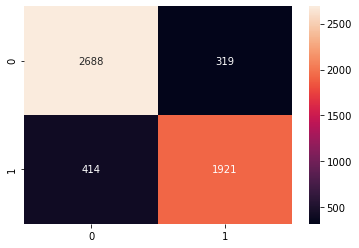

In [52]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

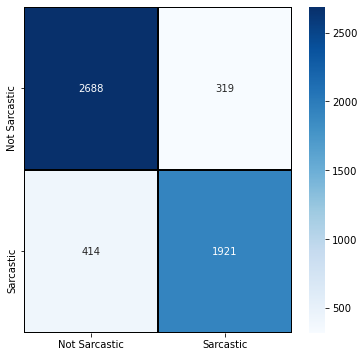

In [53]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# BERT, NLP text classification killer

In [54]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [55]:
%%time
import tensorflow_hub as hub 
import tokenization

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 8.29 s, sys: 1.85 s, total: 10.1 s
Wall time: 10.6 s


In [56]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [57]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Remember in previous sections, we have explored on the headline length. Most of them has a length between 50 to 150, and the majority has a length of 70. We set the length to 120.

In [58]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.headline, df['is_sarcastic'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

Let's build the model and train on it.

In [59]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [60]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_history = model.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

Train on 21634 samples, validate on 2404 samples
Epoch 1/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8710
Epoch 00001: val_accuracy improved from -inf to 0.91514, saving model to model.h5
21634/21634 [==============================] - 304s 14ms/sample - loss: 0.3028 - accuracy: 0.8710 - val_loss: 0.2094 - val_accuracy: 0.9151
Epoch 2/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9454
Epoch 00002: val_accuracy improved from 0.91514 to 0.92055, saving model to model.h5
21634/21634 [==============================] - 289s 13ms/sample - loss: 0.1524 - accuracy: 0.9454 - val_loss: 0.2014 - val_accuracy: 0.9205
Epoch 3/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9712
Epoch 00003: val_accuracy improved from 0.92055 to 0.92637, saving model to model.h5
21634/21634 [==============================] - 289s 13ms/sample - loss: 0.0817 - accuracy: 0.9712 - val_loss: 0.2915 - val

In [61]:
%%time
model.load_weights('model.h5')
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds))

Validation accuracy:  0.9254960688880569
CPU times: user 10.9 s, sys: 169 ms, total: 11.1 s
Wall time: 11.3 s


In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = y_preds
y_test=y_val

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

# print('\nTRAIN METRIC ----------------------')
# print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[1422   74]
 [ 125 1050]]

============TEST METRICS=============
Accuracy: 92.5496068888057%
Precision: 93.41637010676158%
Recall: 89.36170212765957%
F1-score: 91.34406263592868


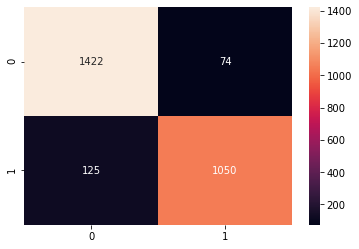

In [63]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

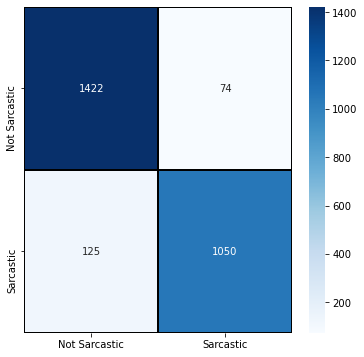

In [64]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

* The validation accuracy is `92%`, impressive !

The result can be further improved by: 
1. increasing the length of `max_len`, i.e., the length of input headline length 
2. fine-tuning parameters 
3. trying other pretrained bert modules.

To summarize, BERT is definitely the winner of text classification tasks.